In [ ]:
import tensorflow as tf
import gc
import os
import numpy as np
import tensorflow_datasets as tfds

In [ ]:
resolver = tf.distribute.cluster_resolver.TPUClusterResolver(tpu='')
tf.config.experimental_connect_to_cluster(resolver)
# This is the TPU initialization code that has to be at the beginning.
tf.tpu.experimental.initialize_tpu_system(resolver)
print("All devices: ", tf.config.list_logical_devices('TPU'))

All devices:  [LogicalDevice(name='/job:worker/replica:0/task:0/device:TPU:0', device_type='TPU'), LogicalDevice(name='/job:worker/replica:0/task:0/device:TPU:1', device_type='TPU'), LogicalDevice(name='/job:worker/replica:0/task:0/device:TPU:2', device_type='TPU'), LogicalDevice(name='/job:worker/replica:0/task:0/device:TPU:3', device_type='TPU'), LogicalDevice(name='/job:worker/replica:0/task:0/device:TPU:4', device_type='TPU'), LogicalDevice(name='/job:worker/replica:0/task:0/device:TPU:5', device_type='TPU'), LogicalDevice(name='/job:worker/replica:0/task:0/device:TPU:6', device_type='TPU'), LogicalDevice(name='/job:worker/replica:0/task:0/device:TPU:7', device_type='TPU')]


In [ ]:
strategy = tf.distribute.TPUStrategy(resolver)

In [ ]:
!pip install hickle
import hickle as hkl
import os
import matplotlib.pyplot as plt
from keras import layers,Input,Sequential
from keras.layers import Dense,Flatten,Reshape,Conv2DTranspose,Conv2D,MaxPooling2D,Reshape,Resizing,Dropout,UpSampling2D
from tensorflow.keras import datasets, layers, models, losses, Model
from random import randint
import numpy as np
from tensorflow.keras import layers
from tensorflow.keras.models import Sequential,Model
import matplotlib.pyplot as plt
from google.colab  import drive
drive.mount("/gdrive")
%cd /gdrive

Drive already mounted at /gdrive; to attempt to forcibly remount, call drive.mount("/gdrive", force_remount=True).
/gdrive


In [ ]:
with strategy.scope():
    load_locally = tf.saved_model.LoadOptions(experimental_io_device='/job:localhost')
    reconstructed_front = tf.keras.models.load_model('/gdrive/My Drive/Yedek1/Models_Static_v1/Frontal', options=load_locally)
    reconstructed_left= tf.keras.models.load_model('/gdrive/My Drive/Yedek1/Models_Static_v1/Left', options=load_locally)
    reconstructed_right = tf.keras.models.load_model('/gdrive/My Drive/Yedek2/Models_Static_v1/Right', options=load_locally)

In [ ]:
load_hkl = hkl.load("/gdrive/My Drive/Yedek/Autoencoder_Datasets_filtered_v1/Static/Frontal.hkl")
X_train_frontal=load_hkl['xtrain'] / 255.
X_test_frontal=load_hkl['xtest'] / 255.
y_train_frontal=load_hkl['ytrain']
y_test_frontal=load_hkl['ytest']
del load_hkl
gc.collect()

325

In [ ]:
load_hkl = hkl.load("/gdrive/My Drive/Yedek/Autoencoder_Datasets_filtered_v1/Static/Left.hkl")
X_train_left=load_hkl['xtrain'] / 255.
X_test_left=load_hkl['xtest'] / 255.

del load_hkl
gc.collect()


0

In [ ]:

load_hkl = hkl.load("/gdrive/My Drive/Yedek/Autoencoder_Datasets_filtered_v1/Static/Right.hkl")
X_train_right=load_hkl['xtrain'] / 255.
X_test_right=load_hkl['xtest'] / 255.

del load_hkl
gc.collect()

0

In [ ]:
xm_train_frontal=reconstructed_front.encoder(X_train_frontal)
xm_test_frontal=reconstructed_front.encoder(X_test_frontal)
del X_train_frontal
del X_test_frontal
gc.collect()

0

In [ ]:
xm_train_left=reconstructed_left.encoder(X_train_left)
xm_test_left=reconstructed_left.encoder(X_test_left)
del X_train_left
del X_test_left
gc.collect()

0

In [ ]:
xm_train_right=reconstructed_right.encoder(X_train_right)
xm_test_right=reconstructed_right.encoder(X_test_right)
del X_train_right
del X_test_right
gc.collect()

0

In [ ]:
xm_train_frontal=tf.reshape(xm_train_frontal,[xm_train_frontal.shape[0],-1])
xm_test_frontal=tf.reshape(xm_test_frontal,[xm_test_frontal.shape[0],-1])

xm_train_left=tf.reshape(xm_train_left,[xm_train_left.shape[0],-1])
xm_test_left=tf.reshape(xm_test_left,[xm_test_left.shape[0],-1])

xm_train_right=tf.reshape(xm_train_right,[xm_train_right.shape[0],-1])
xm_test_right=tf.reshape(xm_test_right,[xm_test_right.shape[0],-1])

In [ ]:
xm_train_left.shape

TensorShape([194, 614400])

In [ ]:
xm_test_left.shape

TensorShape([83, 614400])

In [ ]:
xm_train_right.shape

TensorShape([194, 614400])

In [ ]:
xm_test_right.shape

TensorShape([83, 614400])

In [ ]:
xm_train_frontal.shape

TensorShape([194, 614400])

In [ ]:
xm_test_frontal.shape

TensorShape([83, 614400])

# **Fusion of front, left and right vectors**

In [ ]:
  xm_train=np.empty((xm_train_frontal.shape[0],0),dtype='float32')
  y_train=y_train_frontal
  xm_test=np.empty((xm_test_frontal.shape[0],0),dtype='float32')
  y_test=y_test_frontal

  xm_train=np.concatenate((xm_train,xm_train_frontal),axis=1)
  xm_train=np.concatenate((xm_train,xm_train_left),axis=1)
  xm_train=np.concatenate((xm_train,xm_train_right),axis=1)

  xm_test=np.concatenate((xm_test,xm_test_frontal),axis=1)
  xm_test=np.concatenate((xm_test,xm_test_left),axis=1)
  xm_test=np.concatenate((xm_test,xm_test_right),axis=1)

  del xm_train_frontal
  del xm_train_left
  del xm_train_right

  del xm_test_frontal
  del xm_test_left
  del xm_test_right
  gc.collect()

0

In [ ]:
  print(xm_train.shape)
  print(xm_test.shape)

(194, 1843200)
(83, 1843200)


## **Machine Learning**

In [ ]:
from sklearn.metrics import classification_report

In [ ]:
from sklearn.preprocessing import StandardScaler

scaler=StandardScaler()

xm_train=scaler.fit_transform(xm_train)
xm_test=scaler.transform(xm_test)

In [ ]:
from sklearn.svm import SVC

svc=SVC(kernel="sigmoid")
svc.fit(xm_train, y_train)

SVC(kernel='sigmoid')

In [ ]:
y_pred=svc.predict(xm_test)

from sklearn.metrics import confusion_matrix, ConfusionMatrixDisplay

cm=confusion_matrix(y_test, y_pred)
print(cm)
print(classification_report(y_test, y_pred))

[[51  2]
 [ 7 23]]
              precision    recall  f1-score   support

         0.0       0.88      0.96      0.92        53
         1.0       0.92      0.77      0.84        30

    accuracy                           0.89        83
   macro avg       0.90      0.86      0.88        83
weighted avg       0.89      0.89      0.89        83



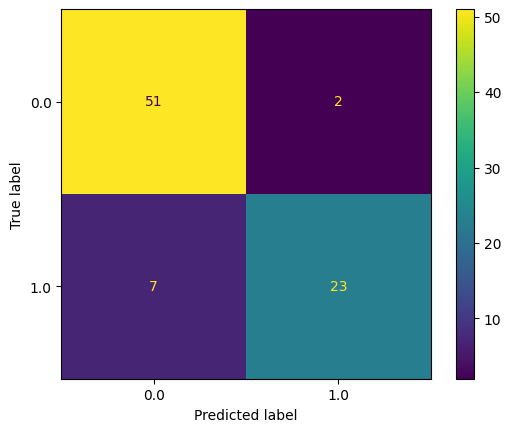

In [ ]:
disp = ConfusionMatrixDisplay(confusion_matrix=cm, display_labels=svc.classes_)
disp.plot()